<a href="https://colab.research.google.com/github/eabarnes1010/ml_tutorial_ncat/blob/main/code/Predict_ENSO_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a neural network to predict the ENSO class

##### SST mean data downloaded from NOAA NCEI Extended Reconstructed Sea Surface Temperature
* https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html

##### Nino34 Index calculation computed generally following below website, but included detrending data
* https://foundations.projectpythia.org/core/xarray/enso-xarray.html

In [3]:
%pip install seaborn cartopy fsspec requests aiohttp h5netcdf

import xarray as xr
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.colors as mcolors

import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Preprocess Data

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


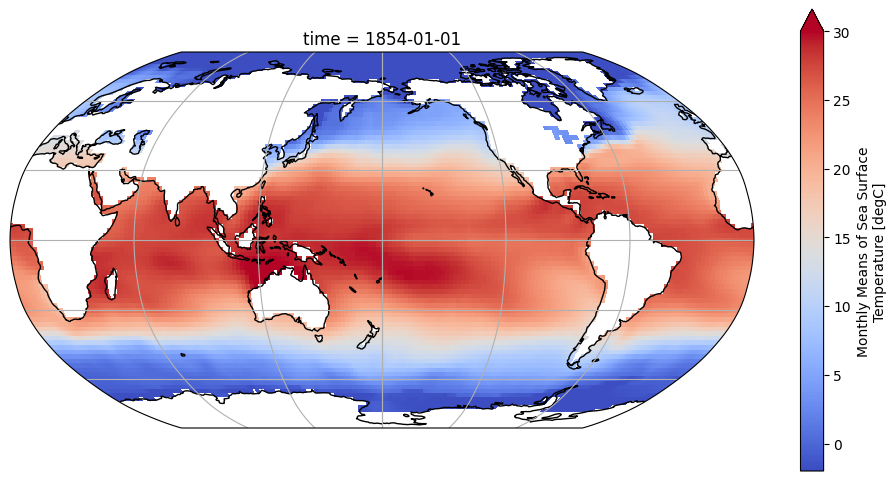

In [4]:
# sst_data_raw = xr.open_dataset("sst.mnmean.nc") # if stored locally

url = "https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc"
sst_data_raw = xr.open_dataset(fsspec.open(url).open())
sst_ds = sst_data_raw.sst

# Plot the first time step of the SST data
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.coastlines()
ax.gridlines()
sst_ds.isel(time=0).plot(
    ax=ax, transform=ccrs.PlateCarree(), vmin=-2, vmax=30, cmap="coolwarm"
)

## Compute monthly anomalies via removing climatology (1970-1999) for area averaged total SST from Nino34 region

In [5]:
# Select Baseline Period to Compute Climatology
sst_data_climo_slice = sst_ds.sel(time=slice("1970-01-01", "1999-12-31"))

# Compute the monthly climatology over selected period
climatology = sst_data_climo_slice.groupby("time.month").mean(dim="time")

# Calculate anomalies by removing the monthly climatology from the original SST data
tos_nino34_anom = sst_ds.groupby("time.month") - climatology

## Compute area-averaged total SST from Nino34 region

In [6]:
index_nino34 = tos_nino34_anom.sel(
    lat=slice(5, -5), lon=slice(190, 240)
)  # use lat/lon coordinates of specified region

weights = np.cos(
    np.deg2rad(tos_nino34_anom["lat"])
)  # weights for the cosine of latitude

tos_nino34 = index_nino34.weighted(weights).mean(("lon", "lat"))

## Detrend the data to remove the influence of long-term climate change

Slope of the linear trend: 0.0004


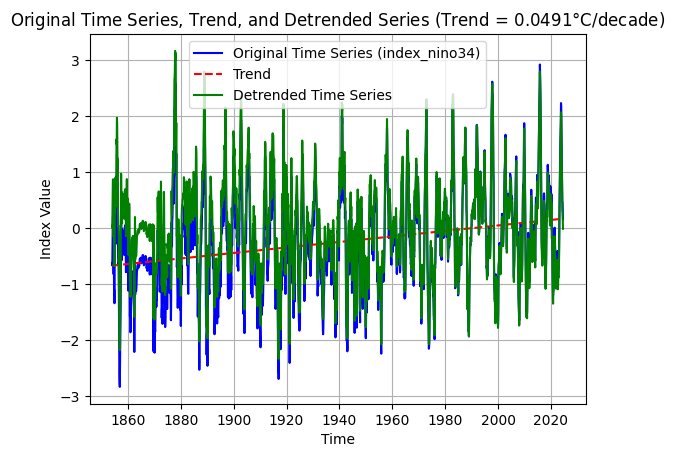

In [7]:
# Detrending the time series by first calculating the linear trend
time_numeric = np.arange(len(tos_nino34.time))

# Fit a linear regression to the time series to get the trend
coeffs = np.polyfit(time_numeric, tos_nino34, 1)  # Linear fit (degree=1)

# Extract the slope and intercept
slope = coeffs[0]  # Slope of the trend line
intercept = coeffs[1]  # Intercept of the trend line

# Create the trend line
trend = slope * time_numeric + intercept  # Create the trend line

# Detrend the time series by subtracting the trend from the original data
detrended_nino34 = tos_nino34 - trend

# Compute R-squared value
ss_res = np.sum((tos_nino34 - trend) ** 2)  # Residual sum of squares (SS_res)
ss_tot = np.sum(
    (tos_nino34 - np.mean(index_nino34)) ** 2
)  # Total sum of squares (SS_tot)
r_squared = 1 - (ss_res / ss_tot)

# Print the R² value
print(f"Slope of the linear trend: {slope:.4f}")

plt.plot(
    index_nino34.time,
    tos_nino34,
    label="Original Time Series (index_nino34)",
    color="blue",
)
plt.plot(index_nino34.time, trend, label="Trend", color="red", linestyle="--")
plt.plot(
    index_nino34.time, detrended_nino34, label="Detrended Time Series", color="green"
)

plt.title(
    f"Original Time Series, Trend, and Detrended Series (Trend = {slope*120:.4f}"
    + r"$\degree$C/decade)"
)
plt.xlabel("Time")
plt.ylabel("Index Value")
plt.legend()
plt.grid(True)
plt.show()

## Smooth data with a 5-month running mean

In [8]:
# Smooth the index with a 5-month rolling mean
nino34 = detrended_nino34.rolling(time=5, center=True).mean()

## Plot Nino 3.4 Index to visualize data

Text(0.5, 1.0, 'Niño 3.4 Index')

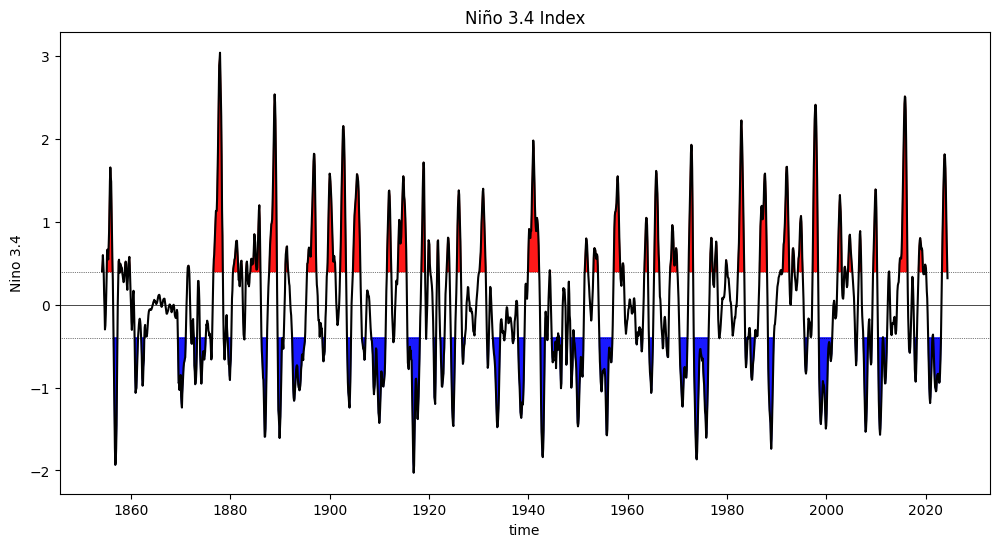

In [9]:
fig = plt.figure(figsize=(12, 6))

plt.fill_between(
    nino34.time.data,
    nino34.where(nino34 >= 0.4).data,
    0.4,
    color="red",
    alpha=0.9,
)
plt.fill_between(
    nino34.time.data,
    nino34.where(nino34 <= -0.4).data,
    -0.4,
    color="blue",
    alpha=0.9,
)

nino34.plot(color="black")
plt.ylabel("Nino 3.4")
plt.axhline(0, color="black", lw=0.5)
plt.axhline(0.4, color="black", linewidth=0.5, linestyle="dotted")
plt.axhline(-0.4, color="black", linewidth=0.5, linestyle="dotted")
plt.title("Niño 3.4 Index")

# Split Data into train/val/test

In [10]:
nino34 = nino34.dropna(dim="time")  # shorten variable name

# Create a new variable that classifies the Nino3.4 index into 3 categories
# 0 = La Nina, 1 = Neutral, 2 = El Nino
nino34_class = xr.DataArray(
    np.where(nino34 >= 0.5, 2, np.where(nino34 <= -0.5, 0, 1)),
    coords=[nino34.time],
    dims=["time"],
)

print("El Nino samples: ", int(np.sum(nino34_class == 2)))
print("La Nina samples: ", int(np.sum(nino34_class == 0)))
print("Neutral samples: ", int(np.sum(nino34_class == 1)))

El Nino samples:  503
La Nina samples:  563
Neutral samples:  978


In [11]:
# Get the years from the time coordinate
years = np.array(sorted(np.unique(nino34.time.dt.year.values)))

# Calculate the number of years for each split
train_size = int(
    0.7 * len(years)
)  # 70% for training; takes integer value for closest year split
val_size = int(0.15 * len(years))  # 15% for validation
test_size = len(years) - train_size - val_size  # The rest for testing

# Split the years sequentially
train_years = years[:train_size]
val_years = years[train_size : train_size + val_size]
test_years = years[train_size + val_size :]

# Create boolean masks to select data by year using xarray DataArrays
train_mask = xr.DataArray(
    np.isin(nino34.time.dt.year, train_years), dims="time", coords={"time": nino34.time}
)
val_mask = xr.DataArray(
    np.isin(nino34.time.dt.year, val_years), dims="time", coords={"time": nino34.time}
)
test_mask = xr.DataArray(
    np.isin(nino34.time.dt.year, test_years), dims="time", coords={"time": nino34.time}
)

# Apply masks to get training, validation, and testing sets
sst_train = nino34.where(train_mask, drop=True)
sst_val = nino34.where(val_mask, drop=True)
sst_test = nino34.where(test_mask, drop=True)

nino_train = nino34_class.where(train_mask, drop=True)
nino_val = nino34_class.where(val_mask, drop=True)
nino_test = nino34_class.where(test_mask, drop=True)

## Plot data to visualize data split

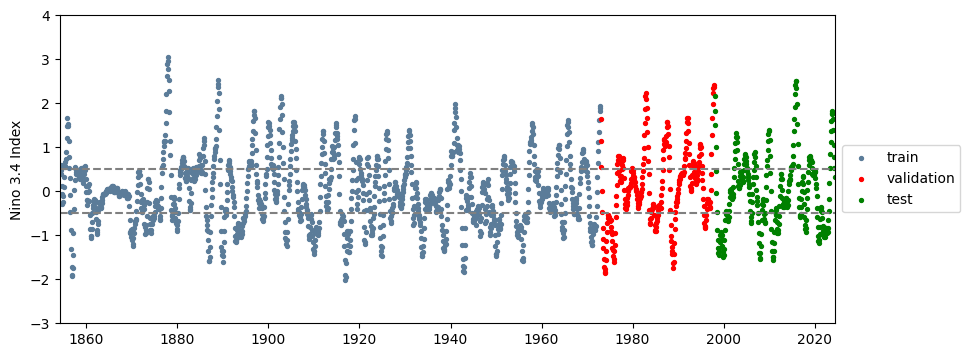

In [12]:
# Ensure that the time coordinate is properly accessed and handled
time_data = nino34.time.values

# Create masks for each condition
el_nino_mask = nino34 >= 0.5
la_nina_mask = nino34 <= -0.5
neutral_mask = (nino34 > -0.5) & (nino34 < 0.5)

# Plot scatter plot for training data (El Niño, La Niña, and Neutral combined)
plt.figure(figsize=(10, 4))
plt.scatter(
    time_data[train_mask.values & (el_nino_mask | la_nina_mask | neutral_mask).values],
    nino34[train_mask & (el_nino_mask | la_nina_mask | neutral_mask)],
    color="xkcd:slate blue",
    s=8,
    label="train",
)

# Plot scatter plot for validation data
plt.scatter(
    time_data[val_mask.values & (el_nino_mask | la_nina_mask | neutral_mask).values],
    nino34[val_mask & (el_nino_mask | la_nina_mask | neutral_mask)],
    color="red",
    s=8,
    label="validation",
)

# Plot scatter plot for test data
plt.scatter(
    time_data[test_mask.values & (el_nino_mask | la_nina_mask | neutral_mask).values],
    nino34[test_mask & (el_nino_mask | la_nina_mask | neutral_mask)],
    color="green",
    s=8,
    label="test",
)

# Add horizontal lines for El Niño and La Niña thresholds
plt.hlines(
    0.5, nino_train.time[0], nino_test.time[-1], linestyle="dashed", color="grey"
)
plt.hlines(
    -0.5, nino_train.time[0], nino_test.time[-1], linestyle="dashed", color="grey"
)

# Set plot limits and labels
plt.xlim(nino_train.time[0], nino_test.time[-1])
plt.ylim(-3, 4)
plt.ylabel("Nino 3.4 Index")

# Add legend
plt.legend(bbox_to_anchor=(1, 0.4, 0.1, 0.2))

# Show the plot
plt.show()

## Normalize data with training data standard deviation

In [13]:
# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)

# Normalize SST data using the training standard deviation (sst_std)
sst_std = np.std(sst_train, axis=0)

# Standardize the train, validation, and test data by dividing by sst_std
sst_train = np.divide(sst_train, sst_std)
sst_train[np.isnan(sst_train)] = 0  # Set NaNs to zero in the training data

sst_val = np.divide(sst_val, sst_std)
sst_val[np.isnan(sst_val)] = 0  # Set NaNs to zero in the validation data

sst_test = np.divide(sst_test, sst_std)
sst_test[np.isnan(sst_test)] = 0  # Set NaNs to zero in the test data

# Need to convert xarray DataArray to NumPy arrays using the .values attribute
sst_train_np = sst_train.values  # Extract NumPy array from xarray DataArray
nino_train_np = nino_train.values  # Similarly for labels

sst_val_np = sst_val.values
nino_val_np = nino_val.values

sst_test_np = sst_test.values
nino_test_np = nino_test.values

# Reshape the data to ensure each sample has one feature
sst_train_np = sst_train_np.reshape(-1, 1)
sst_val_np = sst_val_np.reshape(-1, 1)
sst_test_np = sst_test_np.reshape(-1, 1)

In [14]:
print(sst_train_np.shape)  # Should be (num_samples, num_features)
print(nino_train_np.shape)  # Should be (num_samples,)

(1426, 1)
(1426,)


# Neural Network Setup

##### The preprocessing of the input and output data is complete. Now, we set up the neural networks to made our predictions.

## Hyperparameter Selection

In [15]:
hiddens = [12, 12]  # Hidden layers: Two layers with 12 nodes each
ridgepen = 1  # L2 regularization (Ridge penalty)
lr = 1e-3  # Learning rate for the optimizer
n_epochs = 20  # Number of epochs to train the model
batch_size = 32  # Batch size for training
# activation = nn.ReLU()  # relu activitation function included in classifier below
output_nodes = 3  # Number of output nodes (three-class for ENSO)
input_size = sst_train_np.shape[1]

## Define the network

In [16]:
class ENSOPredictor(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super(ENSOPredictor, self).__init__()
        self.layers = nn.ModuleList()

        # Add the first hidden layer
        self.layers.append(nn.Linear(input_size, hidden_layers[0]))

        # Add additional hidden layers
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))

        # Add the output layer
        self.layers.append(nn.Linear(hidden_layers[-1], output_size))

    def forward(self, x):
        # Pass input through each hidden layer with ReLU activation
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        # Output layer with softmax activation
        return torch.softmax(self.layers[-1](x), dim=1)

In [17]:
# Convert numpy arrays (sst and nino data) to PyTorch tensors
train_data = torch.tensor(
    sst_train_np, dtype=torch.float32
)  # Feature data for training
train_labels = torch.tensor(
    nino_train_np, dtype=torch.long
)  # Class labels (should be integer-based for classification)

val_data = torch.tensor(sst_val_np, dtype=torch.float32)  # Feature data for validation
val_labels = torch.tensor(nino_val_np, dtype=torch.long)  # Validation labels

test_data = torch.tensor(sst_test_np, dtype=torch.float32)  # Feature data for testing
test_labels = torch.tensor(nino_test_np, dtype=torch.long)  # Testing labels

# Verify the shapes to ensure correctness
print(train_data.shape)  # Should be (num_samples, 1)
print(train_labels.shape)  # Should be (num_samples,)
print(val_data.shape)  # Should be (num_samples, 1)
print(val_labels.shape)  # Should be (num_samples,)
print(test_data.shape)  # Should be (num_samples, 1)
print(test_labels.shape)  # Should be (num_samples,)

# To store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

torch.Size([1426, 1])
torch.Size([1426])
torch.Size([300, 1])
torch.Size([300])
torch.Size([318, 1])
torch.Size([318])


In [18]:
# Instantiate the model with the specified parameters
model = ENSOPredictor(input_size, hiddens, output_nodes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(
    model.parameters(), lr=lr
)  # Adam optimizer with L2 regularization

# Create DataLoader without modifying the original dataset
# DataLoaders are helpful for batching to streamline the process of feeding data into the model
train_dataset = TensorDataset(train_data, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_data, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training loop
for epoch in range(n_epochs):
    model.train()
    running_loss = (
        0.0  # Store variables to comput loss and accuracy as a function of epoch
    )
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        outputs = model(inputs)  #  Make predictions for current batch of inputs
        loss = criterion(
            outputs, labels
        )  #  Calculate loss based on predictions and actual labels

        optimizer.zero_grad()  #  Zero out the gradients from the previous iteration
        loss.backward()  #  Backpropagate the loss
        optimizer.step()  #  Update the model parameters based on the gradients

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  #  Get the predicted class labels
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += (
                loss.item()
            )  #  Accumulate the validation loss to compute avrage validation loss
            _, predicted = torch.max(outputs, 1)  #  Get the predicted class labels
            total_val += labels.size(0)  #  Accumulate the total number of samples
            correct_val += (
                (predicted == labels).sum().item()
            )  #  Accumulate the number of correct predictions

    val_losses.append(val_loss / len(val_loader))
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    # print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}, Val Loss: {val_loss/len(val_loader)}, Val Accuracy: {correct/total}')

## Evaluate Model on Test Data

In [19]:
#  We want to retain the original indices of the test data for extracting predictions for composites

test_dataset = TensorDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize variables
correct = 0
total = 0
correct_predictions_indices = []  # Store the indices of correct predictions

# Evaluation phase for test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(test_loader):
        # Get predictions
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class

        # Calculate the number of correct predictions
        correct_predictions = predicted == labels

        # Accumulate correct predictions and total samples
        correct += correct_predictions.sum().item()
        total += labels.size(0)

        # Calculate the start index for this batch
        start_idx = batch_idx * batch_size

        # Collect the indices of correct predictions
        correct_indices = torch.arange(start_idx, start_idx + len(predicted))[
            correct_predictions
        ]
        correct_predictions_indices.extend(
            correct_indices.tolist()
        )  # Extend the list with correct indices

# Convert the list of correct indices to a torch tensor
correct_predictions_indices = torch.tensor(correct_predictions_indices)

# Get times of correct predictions (if needed)
correct_times = nino_test.time[correct_predictions_indices]

# Calculate test accuracy
test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.2%}")  # Print as percentage

Test Accuracy: 100.00%


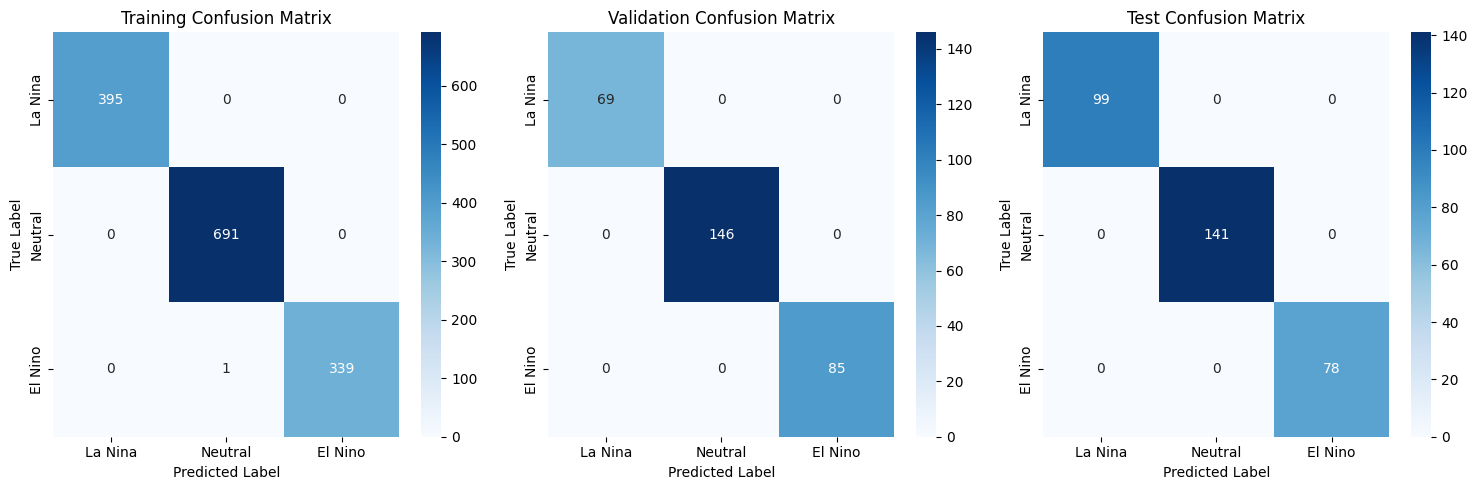

In [20]:
# Function to compute predictions and confusion matrix
def get_confusion_matrix(loader, model):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Concatenate all predictions and labels
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Compute confusion matrix
    return confusion_matrix(all_labels, all_preds)


# Generate confusion matrices for training, validation, and test sets
train_confusion_matrix = get_confusion_matrix(train_loader, model)
val_confusion_matrix = get_confusion_matrix(val_loader, model)
test_confusion_matrix = get_confusion_matrix(test_loader, model)

# Plot confusion matrices side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Define class labels
class_names = ["La Nina", "Neutral", "El Nino"]

# Plot for training confusion matrix
sns.heatmap(
    train_confusion_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    ax=axs[0],
)
axs[0].set_title("Training Confusion Matrix")
axs[0].set_xlabel("Predicted Label")
axs[0].set_ylabel("True Label")

# Plot for validation confusion matrix
sns.heatmap(
    val_confusion_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    ax=axs[1],
)
axs[1].set_title("Validation Confusion Matrix")
axs[1].set_xlabel("Predicted Label")
axs[1].set_ylabel("True Label")

# Plot for test confusion matrix
sns.heatmap(
    test_confusion_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    ax=axs[2],
)
axs[2].set_title("Test Confusion Matrix")
axs[2].set_xlabel("Predicted Label")
axs[2].set_ylabel("True Label")

# Display the plot
plt.tight_layout()
plt.show()

## Plot Composites to help understand network predictions

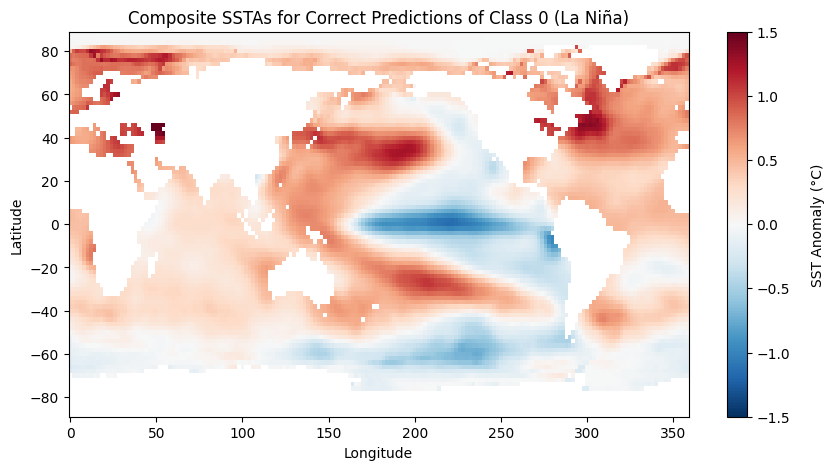

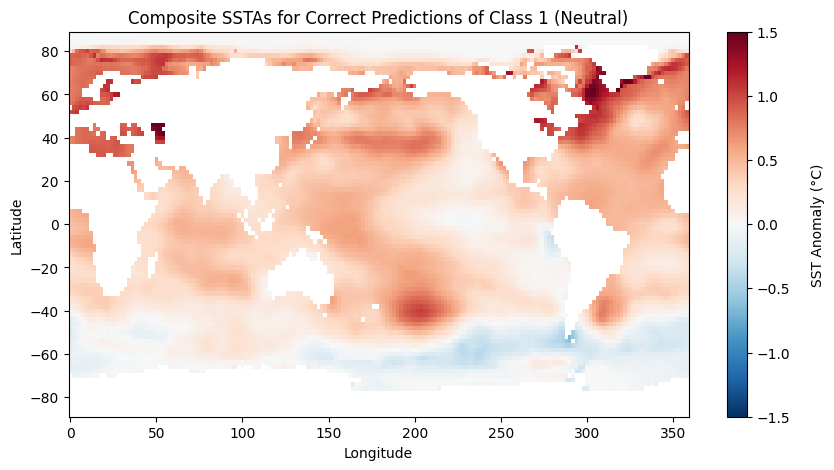

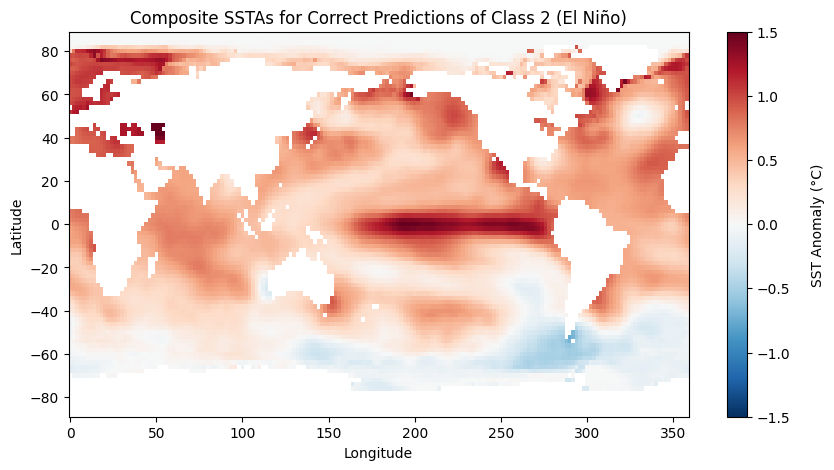

In [21]:
test_labels_tensor = (
    test_labels.clone().detach()
)  # Clone and detach to avoid gradient tracking to convert test_labels to a tensor

# Extract indices for each class based on correct predictions
correct_class_0_indices = correct_predictions_indices[
    test_labels_tensor[correct_predictions_indices] == 0
]  # La Niña
correct_class_1_indices = correct_predictions_indices[
    test_labels_tensor[correct_predictions_indices] == 1
]  # Neutral
correct_class_2_indices = correct_predictions_indices[
    test_labels_tensor[correct_predictions_indices] == 2
]  # El Niño

# Create a custom diverging colormap with white in the middle
cmap = mcolors.TwoSlopeNorm(vmin=-1.5, vcenter=0, vmax=1.5)
custom_cmap = "RdBu_r"


# Function to generate composites for a specific class
def composite_plot(class_indices, class_label, tos_nino34, nino_test):
    # Get the timestamps corresponding to the correct predictions for the specified class
    correct_times = nino_test.time[
        class_indices
    ]  # Adjust according to your time variable

    # Create a mask to select SST data based on correct prediction timestamps
    mask = tos_nino34.time.isin(correct_times)

    # Composite the SST data for the correct predictions of the specified class
    composite_sst = tos_nino34.where(mask, drop=True).mean(dim="time")

    # Plotting the composite SST for the correct predictions of the specified class
    plt.figure(figsize=(10, 5))
    mappable = composite_sst.plot(
        cmap=custom_cmap, norm=cmap, robust=True, add_colorbar=False
    )  # Use the custom colormap

    # Adding colorbar and setting the label
    cbar = plt.colorbar(mappable)
    cbar.set_label(
        "SST Anomaly (°C)", rotation=90, labelpad=15
    )  # Rotate the label and set padding

    plt.title(f"Composite SSTAs for Correct Predictions of Class {class_label}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


# Generate composites for all three classes
composite_plot(correct_class_0_indices, "0 (La Niña)", tos_nino34_anom, nino_test)
composite_plot(correct_class_1_indices, "1 (Neutral)", tos_nino34_anom, nino_test)
composite_plot(correct_class_2_indices, "2 (El Niño)", tos_nino34_anom, nino_test)